# **Fine-Tune Wav2Vec2 XLS-R for Luganda ASR with 🤗 Transformers**

Adapted from [Fine-tuning XLS-R for Multi-Lingual ASR with 🤗 Transformers](https://huggingface.co/blog/fine-tune-xlsr-wav2vec2) and [
Boosting Wav2Vec2 with n-grams in 🤗 Transformers] (https://huggingface.co/blog/wav2vec2-with-ngram)

In [1]:
# Check for GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print("Not connected to a GPU")
else:
    print(gpu_info)

Tue Feb  4 08:53:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A40                     On  |   00000000:25:00.0 Off |                    0 |
|  0%   30C    P0             57W /  300W |       1MiB /  46068MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

#### Install Packages
We shall install `datasets`, `transformers`, `accelerate` for model training. `torchaudio` to load audio files and `jiwer` to evaluate the model using word error rate (WER) and character error rate(CER)

In [8]:
%%capture
!pip install datasets==3.2.0
!pip install transformers==4.48.3
!pip install torchaudio==0.10.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html
!pip install jiwer # jiwer is used for evaluation using WER and CER
!pip install accelerate -U # Restart runtime after running this cell
!pip install wandb
!pip install librosa
!pip install soundfile
!pip install evaluate
!pip install matplotlib
!pip install seaborn
!pip install pyctcdecode

#### IMPORT

In [2]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')

#### Huggingface login

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Install Git-LFS to support uploading model weights to huggingface

In [4]:
%%capture
!apt install git-lfs

### Prepare Data, Tokenizer, Feature Extractor
XLS-R uses the Wav2Vec2CTCTokenizer and the Wav2Vec2FeatureExtractor to process the inputs of the model

#### Create Wav2Vec2CTCTokenizer

#### Download the dataset

In [5]:
from datasets import load_dataset, Audio

In [ ]:
# You need to log in on HuggingFace and accept the terms and conditions of the Mozilla Foundation common voice dataset
lg_cv_train = load_dataset("mozilla-foundation/common_voice_7_0", "lg", split="train+validation", trust_remote_code=True)
lg_cv_test = load_dataset("mozilla-foundation/common_voice_7_0", "lg", split="test", trust_remote_code=True)

In [92]:
# Print the dataset to view a summary of the dataset
print(lg_cv_train)
print(lg_cv_test)

Dataset({
    features: ['audio', 'File No.', 'ENVIRONMENT', 'YEAR', 'AGE', 'GENDER', 'SPEAKER_ID', 'Transcriptions', 'duration'],
    num_rows: 924
})
Dataset({
    features: ['audio', 'File No.', 'ENVIRONMENT', 'YEAR', 'AGE', 'GENDER', 'SPEAKER_ID', 'Transcriptions', 'duration'],
    num_rows: 320
})


In [93]:
# Select a sample from the dataset and view its audio colummn
lg_cv_train[0]['audio']

{'path': None,
 'array': array([0.0184021 , 0.04733276, 0.05471802, ..., 0.00079346, 0.00094604,
        0.00024414]),
 'sampling_rate': 16000}

In [94]:
lg_cv_train = lg_cv_train.select_columns(['audio', 'Transcriptions', 'duration'])
lg_cv_test  = lg_cv_test.select_columns(['audio', 'Transcriptions', 'duration'])

In [95]:
# Use this code to compute number of samples required to make up a total duration of interest
cumsum_length = np.cumsum(lg_cv_train['duration'])
cumsum_length[cumsum_length < 18_000].shape

(923,)

In [96]:
sum(lg_cv_train['duration'])/3600

5.006339826388893

### Display

In [97]:
# Show samples from the dataset
from datasets import ClassLabel
import random
import pandas as pd
from IPython.display import display, HTML


def show_random_elements(dataset, num_examples= 10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = (random.randint(0, len(dataset)-1))
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    display(HTML(df.to_html()))

In [98]:
show_random_elements(lg_cv_train.remove_columns(['audio']))

,Transcriptions,duration
0,zebra bi a wato ahyɛ gyata bi so na mmeranteɛ bi a wɔnhyɛ atade soro na wɔn ho huhuuhu kura mmabaa a wapagyapagya kɔ soro mmeranteɛ mmienu nso nam akyire hɔ a wɔdi mmirika reba baabi a adeɛ no rekɔ so no hɔ nwura mu na wɔwɔ,25.600000
1,edwumayɛfoɔ a wɔwɔ adwumam na hɔn edwuma mu hɔ no abɛɛfo mfidi sisi hɔn enyim hɔn nyinaa wɔatwa atar koro a nahyɛnso yɛ blue wɔde headset ahyehyɛ hɔn tsir,20.136063
2,bɛrema ɔte adekoradeɛ so tetefon ekura no bɛkye si nenim efidie a ɛkye ewia ma kanea esi ne kyɛn apata esi nekyi a wahyehyɛ neɛma wɔ aseɛ,16.240000
3,nnipakuw bi redi asa wɔ beaeɛ bi ebinom rebɔ twene ɛma wɔn a wɔredi asa no wɔhyɛ ataade a nahosuo no mu gu ahodoɔ wɔahyehye nso ahyehyɛ wɔ wɔn ho a wɔatwa kanko redi asa,19.451438
4,sukuufoɔ bi wɔne wɔn kyerɛkyerɛni wɔ science lab mmarima ka ho na mmaa nso ka ho na wɔn kyerɛkyerɛni no yɛ barima wɔn nyinaa hyɛ ataade fitaa tenten na microscope si hɔ a baako te anim,19.440000
5,nkurɔfoɔ bi wɔ hɔ a wɔredrɔdrɔ ade na ɛhwɛ woekyi a wɔadrɔdrɔ nneɛma bebree wɔ hɔ a wɔdze a wɔdze atoto notice board no do na papa bi nso gyina hɔ a ɔka dɛm nkurɔfo no ho nkurɔfo no a wɔwɔ hɔ no wɔn nyinaa yɛ mbaa papa baako pɛ na ɔwɔ mu a ɔnyɛ ɔbaa,23.880000
6,trakta beberee na esisi hɔ trakta no ahosuo ɛyɛ ahahammono na lɔre hyɛn a ɛyɛ kɔkɔɔ ɛnso esi hɔ nnipa bebree egyina trakta no anim na baako de ne nsa akyerɛ trakta no ɛso,18.840000
7,asraafoɔ bebree ɛsan so ɛreba asraafoɔ yi mu bi ɛrenante na ebi nso ɛte ɛhyɛn a ɛdi wɔn a wɔn renante no akyi nwura ɛgu ɛfam ɛhyɛn tumtum bi nso ɛsi ɛkwan no nkyɛn mu,16.400000
8,nnipa nnan bi wɔ abɔnten baabi baako gyina awia mu a okita adua kɛseɛ bi galɔn yɛlo bi nso si hɔ a ade kɔkɔɔ si so,17.397562
9,mmranteɛ gyinagyina hɔ ebi tete dan so ebi nso hyɛ kyɛ na ebi nso hyɛ ahobanmmɔ kyɛ mmranteɛ no mu baako kura dadeɛ baako nso kura nnua mmranteɛ baako nso asosɔ nnua baako mu de reforo dan no,18.040000


In [99]:
# normalize the transcripts. We are not training an orthographic model
def normalize(batch):
    batch['transcription'] = batch['Transcriptions'].lower()
    return batch

lg_cv_train = lg_cv_train.map(normalize)
lg_cv_test = lg_cv_test.map(normalize)

In [22]:
# Obtain the vocabulary from the dataset
def extract_all_chars(batch):
  all_text = " ".join(batch["transcription"])
  vocab = list(set(all_text))
  return {"vocab": [vocab], "all_text": [all_text]}

In [ ]:
luganda_train_vocab   = lg_cv_train.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=lg_cv_train.column_names)
luganda_test_vocab   = lg_cv_test.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=lg_cv_test.column_names)

In [24]:
vocab_list = list(set(luganda_train_vocab["vocab"][0]) | set(luganda_test_vocab["vocab"][0]))

In [25]:
vocab_dict = {v: k for k, v in enumerate(sorted(vocab_list))}
vocab_dict

{' ': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 'ɔ': 27,
 'ɛ': 28,
 '’': 29,
 'ℇ': 30,
 'ↄ': 31}

#### Build Tokenizer and Feature Extactor

In [26]:
# Replace the spaces with |
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]

In [27]:
# Add a padding token that corresponds to CTC blank token
vocab_dict['[UNK]'] = len(vocab_dict)
vocab_dict['[PAD]'] = len(vocab_dict)
len(vocab_dict)

34

In [28]:
# save the vocabulary as a json file
import json
with open('luganda-xls-r.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

In [29]:
# Load the vocabulary into an instance of the Wav2Vec2CTCTokenizer
from transformers import Wav2Vec2CTCTokenizer

tokenizer = Wav2Vec2CTCTokenizer("username/repo", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")

In [ ]:
tokenizer.push_to_hub("username/repo")

#### Create Wav2Vec2FeatureExtractor

In [31]:
from transformers import Wav2Vec2FeatureExtractor

feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=True)

In [32]:
# Wrap the feature extractor and tokenizer in the Wav2Vec2Processor
from transformers import Wav2Vec2Processor

processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

In [ ]:
processor.push_to_hub('username/repo')

In [34]:
# Play an audio sample from the dataset
import IPython.display as ipd
import numpy as np
import random

rand_int = random.randint(0, len(lg_cv_train)-1)
print(lg_cv_train[rand_int]["transcription"])
ipd.Audio(data=np.asarray(lg_cv_train[rand_int]["audio"]["array"]), autoplay=False, rate=16000)

kuro kɛse a wakyɛ mu abien afa na afa na kaal kwan da mfinfin kurow no nemu adan no ebinom yɛ fi tia ebinom yɛ abrosan na kaar dzi mu ndofri wɔrekɔ na wɔreba


In [35]:
lg_cv_train[rand_int]["audio"]["sampling_rate"]

16000

In [36]:
# Plot a graph of the audio
import matplotlib.pyplot as plt
from itertools import cycle

In [37]:
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [38]:
y = lg_cv_train[rand_int]["audio"]["array"]

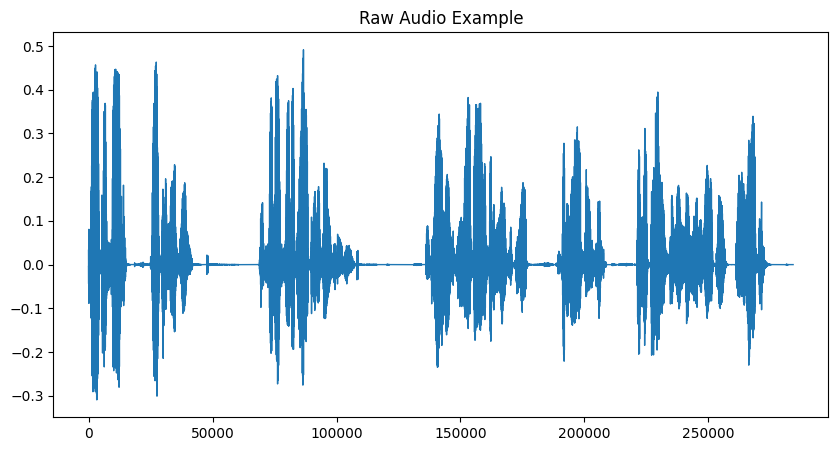

In [39]:
pd.Series(y).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Example',
                 color=color_pal[0])
plt.show()

In [40]:
# Prepare the data for training
def prepare_dataset(batch):
    audio = batch["audio"]

    batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    batch['length'] = batch["duration"]

    with processor.as_target_processor():
        batch["labels"] = processor(batch["transcription"]).input_ids
    return batch

In [41]:
# wolof_kallaama_train = wolof_kallaama_train.cast_column('audio', Audio(16000))
lg_cv_train = lg_cv_train.cast_column('audio', Audio(16000))
lg_cv_test = lg_cv_test.cast_column('audio', Audio(16000))

In [ ]:
# Apply the data preparation function to the data
lg_cv_train = lg_cv_train.map(prepare_dataset, num_proc=8, remove_columns=lg_cv_train.column_names)
lg_cv_test  = lg_cv_test.map(prepare_dataset, num_proc=8, remove_columns=lg_cv_test.column_names)

In [43]:
sum(lg_cv_train['length'])/3600

5.006339826388893

In [44]:
print(lg_cv_train)

Dataset({
    features: ['input_values', 'length', 'labels'],
    num_rows: 924
})


### Training

Create a special collate function that pads the input values to the maximum length in the batch because XLS-R has a very long context length

#### Set-up Trainer

In [45]:
# Apply separate padding to the input and the labels
# Set the padding value to -100 so that the tokens are not taken into account in the loss function

import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
    """
    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split  inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature['input_values']} for feature in features]
        label_features = [{"input_ids": feature['labels']} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding = self.padding,
            return_tensors = "pt",
        )

        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding = self.padding,
                return_tensors = "pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch['input_ids'].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [46]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

In [47]:
# Define the wer and cer metrics
import evaluate

wer_metric = evaluate.load("wer")
cer_metric = evaluate.load("cer")

In [48]:
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)
    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer, "cer": cer}

In [49]:
# Load the Wav2Vec2-XLS-R-300M
from transformers import Wav2Vec2ForCTC

model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-xls-r-300m",
    attention_dropout=0.1,
    hidden_dropout=0.1,
    feat_proj_dropout=0.1,
    mask_time_prob=0.05,
    layerdrop=0.1,
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size=len(processor.tokenizer)
)

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-xls-r-300m and are newly initialized: ['lm_head.bias', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [50]:
model.config.ctc_zero_infinity = True

In [51]:
# Freeze the feature extractor as it has been sufficiently trained
model.freeze_feature_extractor()

In [52]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [53]:
model = model.to(device)

#### Baseline Test

In [74]:
input_dict = lg_cv_test[0]

logits = model(torch.tensor(input_dict["input_values"]).to("cuda").unsqueeze(0)).logits

pred_ids = torch.argmax(logits, dim=-1)[0]

In [75]:
processor.decode(pred_ids)

'jwjtjɲwjêtjêwɛojtjtjtɔ wêt ɲê jɛwtɲtêtɲtjêwêt tjtɲɛmɛwêtjtɲwt ê'

In [76]:
processor.decode(input_dict["labels"]).lower()

'n ko ne de ka kan ka kɛ kana kɛlɛ saraka ye'

In [77]:
# Evaluation is carried out with a batch size of 1
def map_to_result(batch):
  with torch.no_grad():
    input_values = torch.tensor(batch["input_values"], device="cuda").unsqueeze(0)
    logits = model(input_values).logits

  pred_ids = torch.argmax(logits, dim=-1)
  batch["pred_str"] = processor.batch_decode(pred_ids)[0]
  batch["text"] = processor.decode(batch["labels"], group_tokens=False)

  return batch

results = lg_cv_test.map(map_to_result, remove_columns=lg_cv_test.column_names)

Parameter 'function'=<function map_to_result at 0x7fad910a3eb0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/6153 [00:00<?, ? examples/s]

In [78]:
print("Test WER: {:.3f}".format(wer_metric.compute(predictions=results["pred_str"], references=results["text"])))

Test WER: 1.088


In [79]:
print("Test CER: {:.3f}".format(cer_metric.compute(predictions=results["pred_str"], references=results["text"])))

Test CER: 2.291


#### Wandb for Logging and Montoring

In [ ]:
import wandb

wandb.login()

In [55]:
# Wandb arguments
%env WANDB_LOG_MODEL=end
%env WANDB_PROJECT=ASR Africa
%env WANDB_WATCH=all
%env WANDB_SILENT=true

env: WANDB_LOG_MODEL=end
env: WANDB_PROJECT=ASR Africa
env: WANDB_WATCH=all
env: WANDB_SILENT=true


In [56]:
# Define the training arguments
# use the group_by_length argument to make training more efficient

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./rep0",
    group_by_length=True,
    per_device_train_batch_size=32,
    gradient_accumulation_steps=2, # increase the effective batch size to 4,
    per_device_eval_batch_size=16,
    eval_strategy="steps",
    save_strategy ="steps",
    num_train_epochs=50,
    bf16=True, # mixed precision training
    save_steps=500,
    eval_steps=500,
    logging_steps=500,
    learning_rate=3e-4,
    warmup_ratio=0.1,
    save_total_limit=2,
    push_to_hub=True,
    gradient_checkpointing=True,
    report_to="wandb",
    run_name="repo",
    load_best_model_at_end=True,
    hub_private_repo = True,
    torch_compile = True,
    dataloader_num_workers=8,
    dataloader_pin_memory=True,
    dataloader_prefetch_factor=2,
    metric_for_best_model = "wer",  
    greater_is_better=False,
    hub_model_id='asr-africa/repo',
    )

In [57]:
# Pass the model, the training arguments and the data collator to the Trainer

from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=lg_cv_train,
    eval_dataset=lg_cv_test,
    tokenizer=processor.feature_extractor,
)

In [58]:
import numpy as np

In [ ]:
trainer.train()
wandb.finish()
trainer.push_to_hub('username/repo')

### Test Model

In [ ]:
model = Wav2Vec2ForCTC.from_pretrained(
    'username/repo',
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size=len(processor.tokenizer)
)

In [62]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [63]:
model = model.to(device)

In [64]:
input_dict = lg_cv_test[0]

logits = model(torch.tensor(input_dict["input_values"]).to("cuda").unsqueeze(0)).logits

pred_ids = torch.argmax(logits, dim=-1)[0]

In [ ]:
processor.decode(pred_ids)

In [ ]:
processor.decode(input_dict["labels"]).lower()

In [ ]:
# Evaluation is carried out with a batch size of 1
def map_to_result(batch):
    model.eval()
    with torch.no_grad():
        input_values = torch.tensor(batch["input_values"], device="cuda").unsqueeze(0)
        logits = model(input_values).logits
    
    pred_ids = torch.argmax(logits, dim=-1)
    batch["pred_str"] = processor.batch_decode(pred_ids)[0]
    batch["text"] = processor.decode(batch["labels"], group_tokens=False)
    batch['duration'] = batch['length']
    
    return batch

results = lg_cv_test.map(map_to_result, remove_columns=lg_cv_test.column_names)

In [68]:
print("Test WER: {:.3f}".format(wer_metric.compute(predictions=results["pred_str"], references=results["text"])))

Test WER: 0.555


In [69]:
print("Test CER: {:.3f}".format(cer_metric.compute(predictions=results["pred_str"], references=results["text"])))

Test CER: 0.178


In [71]:
def calculate_wer_cer(batch):
    batch['WER'] = wer_metric.compute(references=[batch['text']], predictions=[batch['pred_str']])
    batch['CER'] = cer_metric.compute(references=[batch['text']], predictions=[batch['pred_str']])
    return batch

In [ ]:
results = results.map(calculate_wer_cer, num_proc=8)

In [ ]:
show_random_elements(results)

In [74]:
results_df = results.to_pandas()

In [75]:
results_df.to_csv('predictions/results', index =False)

## Build an n-gram language model

In [98]:
with open("text.txt", "w") as file:
  file.write(" ".join(lg_cv_train["Transcriptions"]))

In [101]:
with open("5gram.arpa", "r") as read_file, open("5gram_correct.arpa", "w") as write_file:
  has_added_eos = False
  for line in read_file:
    if not has_added_eos and "ngram 1=" in line:
      count=line.strip().split("=")[-1]
      write_file.write(line.replace(f"{count}", f"{int(count)+1}"))
    elif not has_added_eos and "<s>" in line:
      write_file.write(line)
      write_file.write(line.replace("<s>", "</s>"))
      has_added_eos = True
    else:
      write_file.write(line)

In [ ]:
from transformers import Wav2Vec2Processor

processor = Wav2Vec2Processor.from_pretrained('username/repo')

In [77]:
vocab_dict = processor.tokenizer.get_vocab()
sorted_vocab_dict = {k.lower(): v for k, v in sorted(vocab_dict.items(), key=lambda item: item[1])}

In [ ]:
from pyctcdecode import build_ctcdecoder

decoder = build_ctcdecoder(
    labels=list(sorted_vocab_dict.keys()),
    kenlm_model_path="5gram_correct.arpa",
)

In [79]:
from transformers import Wav2Vec2ProcessorWithLM

processor_with_lm = Wav2Vec2ProcessorWithLM(
    feature_extractor=processor.feature_extractor,
    tokenizer=processor.tokenizer,
    decoder=decoder
)

In [ ]:
from huggingface_hub import Repository

repo = Repository(local_dir="username/repo", clone_from="username/repo")

In [81]:
processor_with_lm.save_pretrained("username/repo")

In [ ]:
!tree -h username/repo

In [84]:
# Create a language model branch to store the language model

repo = Repository(local_dir="username/repo", revision= 'language-model')

Revision `language-model` does not exist. Created and checked out branch `language-model`.



In [ ]:
repo.push_to_hub(commit_message="Update the lm-boosted decoder")

In [ ]:
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC, Wav2Vec2BertForCTC
from transformers import Wav2Vec2ProcessorWithLM

processor = Wav2Vec2ProcessorWithLM.from_pretrained("username/repo")

In [86]:
model = Wav2Vec2ForCTC.from_pretrained("username/repo")

In [87]:
from transformers import pipeline, Wav2Vec2ProcessorWithLM, AutoFeatureExtractor, Wav2Vec2BertForCTC, Wav2Vec2BertProcessor
from transformers.pipelines.pt_utils import KeyDataset
import tqdm
import torch

In [88]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
device

device(type='cuda')

In [89]:
asr = pipeline("automatic-speech-recognition", model=model, device=device, tokenizer=processor.tokenizer, feature_extractor=processor.feature_extractor, decoder = processor.decoder) #  

In [100]:
predictions = [prediction['text'] for prediction in tqdm.tqdm(asr(KeyDataset(lg_cv_test, "audio"), batch_size=16),\
                                                              desc= "Running inference", total= akan_test.num_rows)]

Running inference: 100%|██████████| 320/320 [02:43<00:00,  1.95it/s]


In [101]:
lg_cv_test = lg_cv_test.add_column("predictions", predictions)

In [102]:
print("Test WER: {:.3f}".format(wer_metric.compute(predictions=lg_cv_test["predictions"], references=lg_cv_test["Transcriptions"])))

Test WER: 0.407


In [103]:
print("Test CER: {:.3f}".format(cer_metric.compute(predictions=lg_cv_test["predictions"], references=akan_test["Transcriptions"])))

Test CER: 0.155


In [104]:
def calculate_wer_cer(batch):
    batch['wer'] = wer_metric.compute(references=[batch["Transcriptions"]], predictions=[batch["predictions"]])
    batch['cer'] = cer_metric.compute(references=[batch["Transcriptions"]], predictions=[batch["predictions"]])
    return batch

In [ ]:
lg_cv_test = lg_cv_test.map(calculate_wer_cer, num_proc=9)

In [ ]:
show_random_elements(lg_cv_test.remove_columns(['audio']), 10)

In [107]:
# save the results to a csv file
df = lg_cv_test.remove_columns(['audio']).to_pandas()

df.to_csv('predictions/results-with-lm.csv', index =False)